<a href="https://colab.research.google.com/github/rayxuan2000/E-commerce-Fraud-Detection-and-Risk-Analysis/blob/main/fraudDetection_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Summary of Fraud Detection

There are basically two datasets in this project. One is about fraud detection information, which contains transaction data with different features. There could be normal transactions and fraud cases as well. Another is an IP mapping address which denotes the IP address allocated for different countries. This could be helpful to learn about sources of fraud cases. For this project, there are several points to consider:

- Data is highly imbalanced
- Features of interval_after_signup and time related raw and aggregates are highly predictive of fraud
- Made actionable operation recommendations/proposal for business

# Part 1: Import Data

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# !pip install joblib
import joblib

from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder
%cd /content/drive/My Drive/resume_project/Fraud_detection


ipToCountry = pd.read_csv('IpAddress_to_Country.csv')
fraud_data = pd.read_csv('imbalancedFraudDF.csv')


Mounted at /content/drive
/content/drive/My Drive/resume_project/Fraud_detection


In [3]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [4]:
fraud_data.tail()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
138371,185619,2015-01-09 02:25:03,2015-01-09 02:25:04,30,AVOVPRJNLOLWD,SEO,IE,M,35,8.031690e+08,1
138372,144031,2015-07-07 15:29:10,2015-08-20 01:48:50,67,YLHYGZVPCLHLH,Ads,FireFox,M,23,3.572177e+09,1
138373,58899,2015-04-24 15:28:22,2015-07-16 01:53:25,54,ORSHWNJVUGJFE,Direct,Safari,M,23,1.374693e+08,1
138374,120669,2015-04-14 13:53:32,2015-05-18 23:52:34,31,HNQOJFPCMBRQU,SEO,Chrome,M,31,7.087370e+08,1
138375,157893,2015-02-21 12:47:09,2015-05-18 02:59:16,26,YFUKEEIVTABSH,Ads,Chrome,F,33,1.491168e+09,1


In [5]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,138376.000000,138376.000000,138376.000000,1.383760e+05,138376.000000
mean,200149.032245,36.938985,33.125867,2.154381e+09,0.010226
std,115226.781501,18.321091,8.623645,1.250563e+09,0.100605
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100894.750000,22.000000,27.000000,1.085079e+09,0.000000
50%,200000.500000,35.000000,33.000000,2.156471e+09,0.000000
75%,299745.250000,49.000000,39.000000,3.249150e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [6]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
ipToCountry['country'].value_counts()

country
United States                            46868
Canada                                    6989
Russian Federation                        6739
Australia                                 6316
Germany                                   5999
                                         ...  
Timor-leste                                  1
Korea Democratic People's Republic of        1
St. Pierre and Miquelon                      1
Tokelau                                      1
Saint Lucia                                  1
Name: count, Length: 235, dtype: int64

# Part 2: Data exploration

In [8]:
#Distribution of the label column
fraud_data['class'].value_counts()

class
0    136961
1      1415
Name: count, dtype: int64

Minor group is fraud cases denoted by 1. The ratio is about 1:97. This could lead to serious modeling problem without "modifying" it. I will design several methods in the modeling part. Before that, let

Missing values, outlier?

In [9]:
# count of NaN in each column
fraud_data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

There is no nan value. Check count of fraud that is outliers

In [10]:
numeric_columns = fraud_data.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_columns

['user_id', 'purchase_value', 'age', 'ip_address', 'class']

In [11]:
fraud_data['user_id'].value_counts()

user_id
22058     1
116771    1
328797    1
387363    1
138649    1
         ..
97172     1
339840    1
109306    1
108990    1
157893    1
Name: count, Length: 138376, dtype: int64

The column user_id is all unique so there is no reason to keep it during analysis. Also the value of IP address, big or small, is meaningless. Class is target variable, no need to consider here.

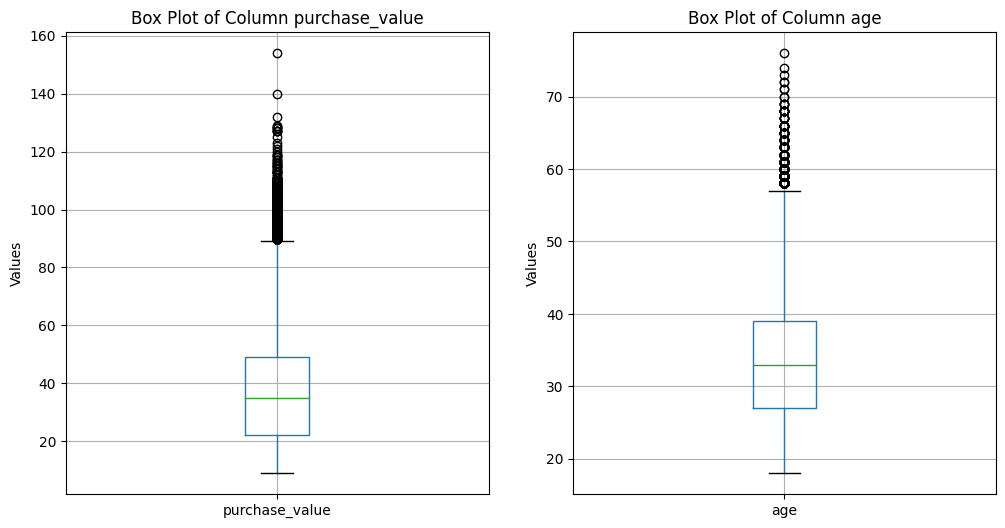

In [12]:
elements_to_delete = ['user_id', 'ip_address', 'class']
column_box_plot = [column for column in numeric_columns if column not in elements_to_delete]


# Create subplots
fig, axes = plt.subplots(1, len(column_box_plot), figsize=(12, 6))

# Create box plot for each column in a row
for i, column in enumerate(column_box_plot):
    fraud_data.boxplot(column=column, ax=axes[i])
    axes[i].set_title('Box Plot of Column {}'.format(column))
    axes[i].set_ylabel('Values')

plt.show()

In [13]:
Q1_A = fraud_data['purchase_value'].quantile(0.25)
Q3_A = fraud_data['purchase_value'].quantile(0.75)
IQR_A = Q3_A - Q1_A

Q1_B = fraud_data['age'].quantile(0.25)
Q3_B = fraud_data['age'].quantile(0.75)
IQR_B = Q3_B - Q1_B

# Threshold for outliers in both columns
threshold_A = Q3_A + 1.5 * IQR_A
threshold_B = Q3_B + 1.5 * IQR_B

# Select rows where values in both columns are outliers
outliers = fraud_data[(fraud_data['purchase_value'] > threshold_A) | (fraud_data['age'] > threshold_B)]
outliers['class'].value_counts()

class
0    1657
1      24
Name: count, dtype: int64

In [14]:
outliers

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
43,262864,2015-05-03 08:12:33,2015-06-01 08:41:48,91,LYTLRYTPUANEC,Ads,Chrome,F,24,3.580177e+09,0
92,257432,2015-03-24 09:08:01,2015-04-06 02:30:40,41,HYRIZVROAHIAM,Ads,Safari,F,60,1.391044e+09,0
213,179481,2015-03-03 16:39:36,2015-05-04 09:00:32,16,XLXAVZSPQYIDG,SEO,Chrome,M,58,4.259263e+09,0
315,50437,2015-07-12 09:29:46,2015-10-04 13:26:32,107,EOGHGCFLIXVGU,SEO,Chrome,M,18,4.097367e+09,0
416,361782,2015-08-14 20:51:53,2015-09-22 02:53:35,90,BQPWVWUMIDPWI,SEO,Safari,F,21,2.399530e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
138138,86112,2015-01-30 16:09:44,2015-05-20 03:04:52,93,ENZTQDOMVGDZW,SEO,IE,M,31,1.792953e+09,1
138190,55072,2015-07-20 17:38:11,2015-09-06 04:01:42,95,IBODKHSTVKFYE,Ads,FireFox,F,38,4.021811e+09,1
138193,313871,2015-01-08 16:46:21,2015-01-08 16:46:22,17,NRANBRUWVRPOT,Direct,IE,M,61,7.494263e+08,1
138202,302255,2015-01-04 12:53:52,2015-01-04 12:53:53,100,GBPPBDBNXCJAY,Direct,Chrome,F,46,1.790937e+09,1


For the data to be more balanced in a way, delete all 0 class (it's only a small portion of the whole 0 class, about 1.2%) and keep 1 class instances (they are precious minor samples!)

In [15]:
indices_with_zero = outliers.index[outliers['class'] == 0].tolist()
print("Row indices with value 0 in column 'class':", indices_with_zero)

Row indices with value 0 in column 'class': [43, 92, 213, 315, 416, 463, 593, 782, 839, 885, 957, 982, 983, 1030, 1050, 1200, 1331, 1381, 1443, 1457, 1639, 1780, 1782, 1896, 1943, 2002, 2047, 2093, 2134, 2166, 2190, 2200, 2261, 2280, 2321, 2405, 2563, 2696, 2722, 2745, 3037, 3063, 3097, 3112, 3264, 3360, 3370, 3515, 3588, 3601, 3729, 3745, 3849, 3898, 3958, 4011, 4139, 4188, 4220, 4305, 4399, 4416, 4647, 4651, 4652, 4779, 4958, 5113, 5305, 5312, 5327, 5391, 5446, 5514, 5595, 5626, 5678, 5685, 5718, 5904, 5987, 6066, 6079, 6112, 6199, 6309, 6402, 6423, 6532, 6713, 6849, 7002, 7295, 7325, 7340, 7411, 7424, 7437, 7442, 7592, 7613, 7667, 7698, 7760, 7861, 7923, 7984, 7991, 8010, 8225, 8389, 8430, 8464, 8654, 8697, 8795, 8858, 8967, 8990, 9024, 9033, 9258, 9356, 9798, 9820, 9835, 9897, 9957, 9990, 10107, 10208, 10252, 10279, 10343, 10464, 10580, 10626, 10754, 10802, 10838, 10857, 10883, 10919, 10923, 11046, 11114, 11186, 11203, 11521, 11537, 11626, 11651, 11694, 11744, 11756, 11790, 12070, 

In [16]:
fraud_data_temp = fraud_data.copy()
fraud_data_clean1 = fraud_data_temp.drop(indices_with_zero).reset_index(drop=True)
# As previously stated, delete user_id column
fraud_data_clean1 = fraud_data_clean1.drop('user_id', axis=1)
fraud_data_clean1

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
...,...,...,...,...,...,...,...,...,...,...
136714,2015-01-09 02:25:03,2015-01-09 02:25:04,30,AVOVPRJNLOLWD,SEO,IE,M,35,8.031690e+08,1
136715,2015-07-07 15:29:10,2015-08-20 01:48:50,67,YLHYGZVPCLHLH,Ads,FireFox,M,23,3.572177e+09,1
136716,2015-04-24 15:28:22,2015-07-16 01:53:25,54,ORSHWNJVUGJFE,Direct,Safari,M,23,1.374693e+08,1
136717,2015-04-14 13:53:32,2015-05-18 23:52:34,31,HNQOJFPCMBRQU,SEO,Chrome,M,31,7.087370e+08,1


Check other columns

In [17]:
fraud_data_clean1['sex'].value_counts()

sex
M    79738
F    56981
Name: count, dtype: int64

In [18]:
fraud_data_clean1['browser'].value_counts()

browser
Chrome     55350
IE         33429
Safari     22371
FireFox    22238
Opera       3331
Name: count, dtype: int64

In [19]:
fraud_data_clean1['source'].value_counts()

source
SEO       55088
Ads       54253
Direct    27378
Name: count, dtype: int64

In [20]:
fraud_data_clean1['device_id'].value_counts()

device_id
QTXDJHIIXYVQN    7
BWSMVSLCJXMCM    6
EQYVNEGOFLAWK    5
HCYSLYNRFLAXU    5
SIAQIUGKLAFIW    5
                ..
XAIZVXXPXBKJZ    1
JLVENQWHILPOH    1
HHPINNLVIJLPA    1
BWOEGZUVLPOQQ    1
YFUKEEIVTABSH    1
Name: count, Length: 132555, dtype: int64

No further findings and we can move on!

## Identify country info based on ip_address


In [21]:
len(ipToCountry)

138846

In [22]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


Now I need to 'INNER JOIN' the two table to make the information more condense. After careful observation, maybe the IP address interval in ipToCountry table have a certain property (ordered in some way). Check that!

In [23]:
less_than = ipToCountry['lower_bound_ip_address'] < ipToCountry['upper_bound_ip_address']
less_than.value_counts()

True     138842
False         4
Name: count, dtype: int64

In [24]:
not_less_than = ipToCountry[~(ipToCountry['lower_bound_ip_address'] < ipToCountry['upper_bound_ip_address'])]

print("Rows where elements in column 'lower_bound_ip_address' are not less than elements in column 'upper_bound_ip_address':")
print(not_less_than)

Rows where elements in column 'lower_bound_ip_address' are not less than elements in column 'upper_bound_ip_address':
        lower_bound_ip_address  upper_bound_ip_address             country
19087             1.540000e+09              1536032767         Netherlands
57069             3.140000e+09              3136004095              Brazil
117727            3.410000e+09              3408000255           Australia
137519            3.650000e+09              3648004095  Russian Federation


These are useless information. So delete them from the original table.

In [25]:
ipToCountry_temp = ipToCountry.copy()
ipToCountry_clean1 = ipToCountry_temp.drop(not_less_than.index.to_list()).reset_index(drop=True)

In [26]:
# Check if value in column 'upper_bound_ip_address' is always less than value in column 'lower_bound_ip_address' in the next row
always_less = all(ipToCountry_clean1['upper_bound_ip_address'].iloc[i] < \
                  ipToCountry_clean1['lower_bound_ip_address'].iloc[i+1] for i in range(len(ipToCountry_clean1)-1))

if always_less:
    print("Value in column 'upper_bound_ip_address' is always less than value in column 'lower_bound_ip_address' in the next row.")
else:
    print("Value in column 'upper_bound_ip_address' is not always less than value in column 'lower_bound_ip_address' in the next row.")

Value in column 'upper_bound_ip_address' is not always less than value in column 'lower_bound_ip_address' in the next row.


In [27]:
rows_not_fulfilled = []
for i in range(len(ipToCountry_clean1)-1):
    if not ipToCountry_clean1['upper_bound_ip_address'].iloc[i] < ipToCountry_clean1['lower_bound_ip_address'].iloc[i+1]:
        rows_not_fulfilled.append(ipToCountry_clean1.iloc[i])
        rows_not_fulfilled.append(ipToCountry_clean1.iloc[i+1])

# Convert the list of rows to a DataFrame
df_not_fulfilled = pd.DataFrame(rows_not_fulfilled)

print("Rows (current and next) where the condition is not fulfilled:")
print(df_not_fulfilled)

Rows (current and next) where the condition is not fulfilled:
        lower_bound_ip_address  upper_bound_ip_address             country
6455              1.023992e+09              1023999999           Singapore
6456              1.020000e+09              1024032767         Philippines
10633             1.151996e+09              1151999999       United States
10634             1.150000e+09              1152008191       United States
30982             1.743999e+09              1743999999          Bangladesh
30983             1.740000e+09              1744001023           Australia
53910             3.103999e+09              3103999999  Russian Federation
53911             3.100000e+09              3104001023      United Kingdom
134774            3.583992e+09              3583999999  Russian Federation
134775            3.580000e+09              3584008191             Ireland
138151            3.663999e+09              3663999743           Australia
138152            3.660000e+09        

But considering that IP allocation is not unique, I will not consider these overlapping case as useless records.

Next, merge two tables (look up IP procedure). Considering the ordered property, I compare two methods: normal merge and binary search.

In [28]:
start = time.time()

countries = []
for i in range(len(fraud_data_clean1)):
    ip_address = fraud_data_clean1.loc[i, 'ip_address']#number
    #check which interval does ip_address falls into
    #below [] is list of T/F, only when this ip_address falls into the correct internal row does the index generate a True
    #tmp is a df of shape n * 3, where n is 1 if found a match (ip_address falls in range) or 0 if no match
    tmp = ipToCountry_clean1[(ipToCountry_clean1['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry_clean1['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('N/A')

# fraud_data['country'] = countries
runtime = time.time() - start

print("Ordinary lookup took", runtime, "seconds.")



Ordinary lookup took 177.21715116500854 seconds.


In [29]:
pd.Series(countries).value_counts()

United States            52226
N/A                      20640
China                    10812
Japan                     6552
United Kingdom            3992
                         ...  
Virgin Islands (U.S.)        1
Dominica                     1
Vanuatu                      1
Niger                        1
Guadeloupe                   1
Name: count, Length: 181, dtype: int64

Optimize the above look-up process by binary search.

In [30]:
start = time.time()

countries = []

for i in range(len(fraud_data_clean1)):
    left, right = 0, len(ipToCountry_clean1)-1
    flag = 0
    while left <= right:
        mid = (left + right)//2
        if fraud_data_clean1.loc[i, 'ip_address'] >= ipToCountry_clean1.loc[mid, 'lower_bound_ip_address'] and \
            fraud_data_clean1.loc[i, 'ip_address'] <= ipToCountry_clean1.loc[mid, 'upper_bound_ip_address']:
            countries.append(ipToCountry.loc[mid, 'country'])
            flag = 1
            break
        elif fraud_data_clean1.loc[i, 'ip_address'] > ipToCountry_clean1.loc[mid, 'upper_bound_ip_address']:
            left = mid + 1
        else:
            right = mid - 1
    if flag == 0:
      countries.append('N/A')

fraud_data_clean2 = fraud_data_clean1.copy()
fraud_data_clean2['country'] = countries
runtime = time.time() - start

print("Binary search lookup took", runtime, "seconds.")

Binary search lookup took 120.57851648330688 seconds.


In [31]:
fraud_data_clean2.head()

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,N/A
3,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,United States


# Part 3a: Feature Engineering - time operation




This part mainly focuses on time-related features. We should consider some arithmetic operations such as time difference to better understand data pattern instead of a specific time.

In [32]:
fraud_data_clean3 = fraud_data_clean2.copy()
# How long does it takes (in seconds) to make a transaction after signup
fraud_data_clean3['interval_after_signup'] = (pd.to_datetime(fraud_data_clean3['purchase_time']) - pd.to_datetime(
        fraud_data_clean3['signup_time'])).dt.total_seconds()


fraud_data_clean3['signup_days_of_year'] = pd.DatetimeIndex(fraud_data_clean3['signup_time']).dayofyear

fraud_data_clean3['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data_clean3['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data_clean3['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data_clean3['signup_time']).hour

fraud_data_clean3['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data_clean3['purchase_time']).dayofyear

fraud_data_clean3['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data_clean3['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data_clean3['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data_clean3['purchase_time']).hour

fraud_data_clean3 = fraud_data_clean3.drop(['signup_time','purchase_time'], axis=1)

In [33]:
fraud_data_clean3.head()
#note there are NAs in country

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,N/A,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,United States,4240931.0,141,21783,190,29114


# Part 4: Data Split

In [34]:
fraud_data_clean4 = fraud_data_clean3.copy()
y = fraud_data_clean4['class']
X = fraud_data_clean4.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (109375, 13)
y_train.shape: (109375,)
X_test.shape: (27344, 13)
y_test.shape: (27344,)


In [35]:
y_train.value_counts(), y_test.value_counts()

(class
 0    108243
 1      1132
 Name: count, dtype: int64,
 class
 0    27061
 1      283
 Name: count, dtype: int64)

It's still imbalanced greatly!

In [36]:
X_train['country'].value_counts(ascending=True)
# drawback: collision in the same bucket(no differentiation for these countries)

country
Mauritania                              1
Virgin Islands (U.S.)                   1
Lao People's Democratic Republic        1
Virgin Islands (BRITISH)                1
Micronesia Federated States of          1
                                    ...  
Brazil                               3041
Japan                                3818
China                                8345
N/A                                 16103
United States                       40446
Name: count, Length: 180, dtype: int64

In [37]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
27197,52,CPZJNYVSIPBPV,Ads,Chrome,M,47,5.134532e+08,United States,7912926.0,143,80063,235,44189
119852,22,DUBTKEIPBMCRE,SEO,Chrome,M,22,4.165680e+08,Canada,9120885.0,167,15825,272,64710
94888,14,MVYQTZOAXYUOI,Direct,FireFox,M,56,4.124441e+09,N/A,1334131.0,90,69721,106,21452
130718,38,JHNLFLJUJNZPD,SEO,IE,F,40,8.737434e+08,United States,1515184.0,116,51022,134,11006
11353,45,KVSWAYRPFWADA,SEO,IE,F,30,2.789671e+06,N/A,2824710.0,6,32505,39,6015


# Part 3b: Feature Engineering - encoding and standardization


Convert categorical features with high cardinality to numericals. And also do other encodings.

In [38]:
X_train_1 = X_train.copy()
# one-hot encoding for 'source' and 'browser' columns
X_train_1 = pd.get_dummies(X_train_1, columns=['source', 'browser'])

# binary encoding (label encoding)
X_train_1['sex'] = (X_train_1.sex == 'M').astype(int)

# The more a device is shared, the more suspicious
# if device_id 'XXX' occurred 100 times in X_train, then replace all 'XXX' in device_id col in X_train by 100
X_train_device_id_mapping = X_train_1.device_id.value_counts(dropna=False)
X_train_1['n_dev_shared'] = X_train_1.device_id.map(X_train_device_id_mapping)# number of times device_id occurred in train data

# The more a ip is shared, the more suspicious
X_train_ip_address_mapping = X_train_1.ip_address.value_counts(dropna=False)
X_train_1['n_ip_shared'] = X_train_1.ip_address.map(X_train_ip_address_mapping)

# The less visit from a country, the more suspicious
X_train_country_mapping = X_train_1.country.value_counts(dropna=False)#include counts of NaN
X_train_1['n_country_shared'] = X_train_1.country.map(X_train_country_mapping)#lots of NAs in country column
# without dropna=False will produce nan in this col

X_train_1 = X_train_1.drop(['device_id','ip_address','country'], axis=1)

In [39]:
X_test_1 = X_test.copy()

X_test_1 = pd.get_dummies(X_test_1, columns=['source', 'browser'])

X_test_1['sex'] = (X_test_1.sex == 'M').astype(int)

# the more a device is shared, the more suspicious
X_test_1['n_dev_shared'] = X_test_1.device_id.map(X_test_1.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test_1['n_ip_shared'] = X_test_1.ip_address.map(X_test_1.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test_1['n_country_shared'] = X_test_1.country.map(X_test_1.country.value_counts(dropna=False))

X_test_1 = X_test_1.drop(['device_id','ip_address','country'], axis=1)

In [40]:
X_train_1.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
27197,52,1,47,7912926.0,143,80063,235,44189,True,False,False,True,False,False,False,False,1,1,40446
119852,22,1,22,9120885.0,167,15825,272,64710,False,False,True,True,False,False,False,False,1,1,2474
94888,14,1,56,1334131.0,90,69721,106,21452,False,True,False,False,True,False,False,False,1,1,16103
130718,38,0,40,1515184.0,116,51022,134,11006,False,False,True,False,False,True,False,False,1,1,40446
11353,45,0,30,2824710.0,6,32505,39,6015,False,False,True,False,False,True,False,False,1,1,16103


Use the same scaler for both train and test data. This is to prevent [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) problem.

In [41]:
X_train_2 = X_train_1.copy()

X_test_2 = X_test_1.copy()
# normalize (min-max) to [0,1]

# standardize(StandardScaler) to normal, mu=0,var = 1 can < 0, so we do normalize here

# needs to be brought to the same scale for models like LR with regularization(that are not tree based)

# Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train_2[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#transform the training data and use them for the model training
X_train_2[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler. \
          transform(X_train_2[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above, on X_test, not fitting a brandnew scaler on test
X_test_2[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler. \
         transform(X_test_2[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

In [42]:
X_train_2.n_dev_shared.value_counts(dropna=False)

n_dev_shared
0.0    104142
0.2      4718
0.4       348
0.6       116
0.8        45
1.0         6
Name: count, dtype: int64

In [43]:
X_test_2.n_dev_shared.value_counts(dropna=False)

n_dev_shared
0.0    27015
0.2      320
0.4        9
Name: count, dtype: int64

# Part 5: Model Training


In fraud detection context, we care about whether we can detect a fraud case correctly if it's a real fraud case - recall. Since this can most effectively reduce the potential loss for the company. On the other hand, if we consider non-fraud case as fraud, in the long run it will affect customer satisfaction, which should also be avoided. But I mainly use **recall** to evaluate. At the same time, precision and f1 will also be presented for comparison.

### Logistic regression

In [44]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_2,y_train)

# predict on test
y_pred_LR=logreg.predict(X_test_2)

In [45]:
cm_LR = metrics.confusion_matrix(y_test, y_pred_LR)
cmDF_LR = pd.DataFrame(cm_LR, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_LR)
print()
print('precision =',precision_score(y_test, y_pred_LR))
print('recall =',recall_score(y_test, y_pred_LR))
print('f1_score =',f1_score(y_test, y_pred_LR))

        pred_0  pred_1
true_0   27061       0
true_1     283       0

precision = 0.0
recall = 0.0
f1_score = 0.0


We can see from the above result that the model just predicts every fraud case as normal. That's due to the imbalanced distribution between positive and negative samples. So later we need to consider this problem.

#### Cross validation with grid search

In [46]:
# It's very time-consuming to use cross validation to measure the model.
# So I comment the cv part code below and load the model that I already saved
# in the folder. You can dis-comment and rerun again if needed.

# # Define the logistic regression model
# logreg = LogisticRegression()

# # Define the hyperparameters to tune
# param_grid = {
#     'penalty': ['l1', 'l2'],           # Regularization type
#     'C': [0.001, 0.01, 0.1, 1, 10],    # Inverse of regularization strength
#     'solver': ['liblinear', 'saga']    # Algorithm to use in the optimization problem
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1')
# grid_search.fit(X_train_2, y_train)

# # Use the best parameters found by grid search
# best_logreg = grid_search.best_estimator_
####################################################################
# Already saved the model

# # Save the model
# joblib.dump(best_logreg, 'best_logreg.joblib')

# Later you can load the model
loaded_lr_model = joblib.load('best_logreg.joblib')
loaded_lr_model.get_params()

# Predict on the test data
y_pred_test_lr = loaded_lr_model.predict(X_test_2)

# Calculate the score on the test data
f1_test = f1_score(y_test, y_pred_test_lr)
recall_test = recall_score(y_test, y_pred_test_lr)
precision_test = precision_score(y_test, y_pred_test_lr)

print("F1 Score on Test Data:", f1_test)
print("Recall Score on Test Data:", recall_test)
print("Precision Score on Test Data:", precision_test)

F1 Score on Test Data: 0.041379310344827586
Recall Score on Test Data: 0.02120141342756184
Precision Score on Test Data: 0.8571428571428571


In [47]:
# Check parameters
loaded_lr_model.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Random forest

In [48]:
classifier_RF = RandomForestClassifier()

classifier_RF.fit(X_train_2, y_train)

# # generate class raw probabilities
# probs = classifier_RF.predict_proba(X_test_2)

# predict class labels 0/1 for the test set
y_pred_RF = classifier_RF.predict(X_test_2)

print ("confusion_matrix is: ")
cm_RF = confusion_matrix(y_test, y_pred_RF)
cmDF_RF = pd.DataFrame(cm_RF, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_RF)
print()
print('precision =',precision_score(y_test, y_pred_RF))
print('recall =',recall_score(y_test, y_pred_RF))
print('f1_score =',f1_score(y_test, y_pred_RF))

confusion_matrix is: 
        pred_0  pred_1
true_0   27061       0
true_1     138     145

precision = 1.0
recall = 0.5123674911660777
f1_score = 0.6775700934579438


The RF result is relatively better than LR. But it is still worth improving. It tends to predict some fraud cases as non-fraud.

#### Cross validation with grid search

In [49]:
# Do the same as above. Save the model and use it.

# # Define the Random Forest model
# rf_classifier = RandomForestClassifier(random_state=42)

# # Define the hyperparameters to tune
# param_grid = {
#     'n_estimators': [100, 200, 300],      # Number of trees in the forest
#     'max_depth': [5, 10, 20],           # Maximum depth of the tree
#     'max_features': ['auto', 'sqrt'],       # Number of features to consider when looking for the best split
#     'class_weight': [{0: 1, 1: w} for w in [2,5,10]] # Class weights
# }

# # Perform grid search with cross-validation
# grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='f1')
# grid_search_rf.fit(X_train_2, y_train)

# # Use the best parameters found by grid search
# best_rf_classifier = grid_search_rf.best_estimator_

#####################################################################

# # Save the model
# joblib.dump(best_rf_classifier, 'best_rf_classifier.joblib')

loaded_rf_model = joblib.load('best_rf_classifier.joblib')

# Predict on the test data
y_pred_test_rf = loaded_rf_model.predict(X_test_2)

# Calculate the score on the test data
f1_test = f1_score(y_test, y_pred_test_rf)
recall_test = recall_score(y_test, y_pred_test_rf)
precision_test = precision_score(y_test, y_pred_test_rf)

print("F1 Score on Test Data:", f1_test)
print("Recall Score on Test Data:", recall_test)
print("Precision Score on Test Data:", precision_test)

F1 Score on Test Data: 0.6775700934579438
Recall Score on Test Data: 0.5123674911660777
Precision Score on Test Data: 1.0


In [50]:
loaded_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### XGboost

In [51]:
import xgboost as xgb
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

xgb_classifier.fit(X_train_2, y_train)

# Predict on the test data
y_pred_GB = xgb_classifier.predict(X_test_2)

print ("confusion_matrix is: ")
cm_GB = confusion_matrix(y_test, y_pred_GB)
cmDF_GB = pd.DataFrame(cm_GB, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_GB)
print()
print('precision =',precision_score(y_test, y_pred_GB))
print('recall =',recall_score(y_test, y_pred_GB))
print('f1_score =',f1_score(y_test, y_pred_GB))

confusion_matrix is: 
        pred_0  pred_1
true_0   27060       1
true_1     161     122

precision = 0.991869918699187
recall = 0.43109540636042404
f1_score = 0.6009852216748769


#### Cross validation with grid search

In [52]:
# import xgboost as xgb
# # Define the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(random_state=42)

# # Define the hyperparameters to tune
# param_grid = {
#     'n_estimators': [50, 100, 200],             # Number of boosting rounds
#     'learning_rate': [0.01, 0.1, 0.5],          # Learning rate shrinks the contribution of each tree
#     'max_depth': [3, 5, 7],                     # Maximum depth of a tree
#     'min_child_weight': [1, 3, 5],              # Minimum sum of instance weight needed in a child
#     'gamma': [0, 0.1, 0.2],                     # Minimum loss reduction required to make a further partition
# }

# # Perform grid search with cross-validation
# grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='f1')
# grid_search_xgb.fit(X_train_2, y_train)


# # Use the best parameters found by grid search
# best_xgb_classifier = grid_search_xgb.best_estimator_

###############################################################
# # Save the model
# joblib.dump(best_xgb_classifier, 'best_xgb_classifier.joblib')

loaded_xgb_model = joblib.load('best_xgb_classifier.joblib')

# Predict on the test data
y_pred_test_xgb = loaded_xgb_model.predict(X_test_2)

# Calculate the score on the test data
f1_test = f1_score(y_test, y_pred_test_xgb)
recall_test = recall_score(y_test, y_pred_test_xgb)
precision_test = precision_score(y_test, y_pred_test_xgb)

print("F1 Score on Test Data:", f1_test)
print("Recall Score on Test Data:", recall_test)
print("Precision Score on Test Data:", precision_test)

F1 Score on Test Data: 0.6267942583732058
Recall Score on Test Data: 0.4628975265017668
Precision Score on Test Data: 0.9703703703703703


In [53]:
loaded_xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [54]:
y_train.value_counts()

class
0    108243
1      1132
Name: count, dtype: int64

The original ratio between minor class and majority class in the training dataset is about 95:1 (very close to original data 97:1). One way of balancing is to supplement training data with multiple copies of some of the minority class.

# Part 6: Resampling

### Oversampling in minor class

Make the ratio become 4:1. Then simply test each algorithm without parameter tuning.

In [55]:
from imblearn.over_sampling import RandomOverSampler

# Combine features and target variable into one DataFrame
train_data_Over = pd.concat([X_train_2, pd.DataFrame(y_train, columns=['class'])], axis=1)

# Count the number of samples in the majority class (class 0)
majority_samples = len(y_train[y_train == 0])

# Calculate the number of samples needed in the minority class to achieve a 4:1 ratio
desired_minority_samples = majority_samples // 4

# Initialize RandomOverSampler with sampling strategy to achieve a 4:1 ratio
ros = RandomOverSampler(sampling_strategy={0: majority_samples, 1: desired_minority_samples})

# Resample the data to achieve the desired ratio
train_data_resampled, YY = ros.fit_resample(train_data_Over.drop(columns=['class']), \
                                            train_data_Over['class'])

# Separate resampled features and target variable
X_train_Over = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
y_train_Over = pd.DataFrame(YY, columns=['class'])

# Check the ratio after resampling
print("Ratio after resampling:")
print(y_train_Over['class'].value_counts(normalize=True))

Ratio after resampling:
class
0    0.800004
1    0.199996
Name: proportion, dtype: float64


Check the validity of result.

In [56]:
# X_train_2, y_train, X_train_Over, y_train_Over
a = pd.concat([X_train_2, pd.DataFrame(y_train, columns=['class'])], axis=1).reset_index(drop=True)
b = pd.concat([X_train_Over, pd.DataFrame(y_train_Over, columns=['class'])], axis=1).reset_index(drop=True)
a.isin(b).all().all()

True

In [57]:
len(y_train_Over)

135303

In [58]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train_Over,y_train_Over)

# predict on test
y_pred_LR_over=logreg.predict(X_test_2)

cm_LR_over = metrics.confusion_matrix(y_test, y_pred_LR_over)
cmDF_LR_over = pd.DataFrame(cm_LR_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_LR_over)
print('precision =',precision_score(y_test, y_pred_LR_over))
print('recall =',recall_score(y_test, y_pred_LR_over))
print('f1_score =',f1_score(y_test, y_pred_LR_over))

        pred_0  pred_1
true_0   26797     264
true_1     157     126
precision = 0.3230769230769231
recall = 0.4452296819787986
f1_score = 0.37444279346210996


In [59]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train_Over, y_train_Over)

# predict class labels 0/1 for the test set
y_pred_RF_over = classifier_RF.predict(X_test_2)

print ("confusion_matrix is: ")
cm_RF_over = confusion_matrix(y_test, y_pred_RF_over)
cmDF_RF_over = pd.DataFrame(cm_RF_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_RF_over)
print('precision =',precision_score(y_test, y_pred_RF_over))
print('recall =',recall_score(y_test, y_pred_RF_over))
print('f1_score =',f1_score(y_test, y_pred_RF_over))

In [60]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

xgb_classifier.fit(X_train_Over, y_train_Over)

# Predict on the test data
y_pred_GB_over = xgb_classifier.predict(X_test_2)

print ("confusion_matrix is: ")
cm_GB_over = confusion_matrix(y_test, y_pred_GB_over)
cmDF_GB_over = pd.DataFrame(cm_GB_over, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_GB_over)
print()
print('precision =',precision_score(y_test, y_pred_GB_over))
print('recall =',recall_score(y_test, y_pred_GB_over))
print('f1_score =',f1_score(y_test, y_pred_GB_over))

confusion_matrix is: 
        pred_0  pred_1
true_0   27036      25
true_1     156     127

precision = 0.8355263157894737
recall = 0.44876325088339225
f1_score = 0.5839080459770115


There is no change on logistic regression and random forest and tiny change on XGBoost. Tune the ratio parameter?

#### Oversampling with hyperparameter tuning.

In [61]:
N = [i for i in range(1, 11)]
best_recall = 0
best_n = 0

for n in N:
    # Count the number of samples in the majority class (class 0)
    majority_samples = len(y_train[y_train == 0])

    # Calculate the number of samples needed in the minority class to achieve a n:1 ratio
    desired_minority_samples = majority_samples // n

    # Initialize RandomOverSampler with sampling strategy to achieve a n:1 ratio
    ros = RandomOverSampler(sampling_strategy={0: majority_samples, 1: desired_minority_samples})

    # Resample the data to achieve the desired ratio
    train_data_resampled, YY = ros.fit_resample(train_data_Over.drop(columns=['class']), \
                                                train_data_Over['class'])

    # Separate resampled features and target variable
    X_train_Over_t = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
    y_train_Over_t = pd.DataFrame(YY, columns=['class'])


    classifier_RF = RandomForestClassifier(random_state=0)

    classifier_RF.fit(X_train_Over_t, y_train_Over_t)

    # predict class labels 0/1 for the test set
    y_pred_RF_over = classifier_RF.predict(X_test_2)

    if best_recall < recall_score(y_test, y_pred_RF_over):
        best_recall = recall_score(y_test, y_pred_RF_over)
        best_n = n
        best_precision =  precision_score(y_test, y_pred_RF_over)
        best_f1 =  f1_score(y_test, y_pred_RF_over)

print('precision =',best_precision)
print('recall =',best_recall)
print('f1_score =',best_f1)
print('best n:',best_n)

precision = 1.0
recall = 0.5123674911660777
f1_score = 0.6775700934579438
best n: 2


In [62]:
N = [i for i in range(1, 11)]
best_recall = 0
best_n = 0

for n in N:
    # Count the number of samples in the majority class (class 0)
    majority_samples = len(y_train[y_train == 0])

    # Calculate the number of samples needed in the minority class to achieve a n:1 ratio
    desired_minority_samples = majority_samples // n

    # Initialize RandomOverSampler with sampling strategy to achieve a n:1 ratio
    ros = RandomOverSampler(sampling_strategy={0: majority_samples, 1: desired_minority_samples})

    # Resample the data to achieve the desired ratio
    train_data_resampled, YY = ros.fit_resample(train_data_Over.drop(columns=['class']), \
                                                train_data_Over['class'])

    # Separate resampled features and target variable
    X_train_Over_t = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
    y_train_Over_t = pd.DataFrame(YY, columns=['class'])


    # Define the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    xgb_classifier.fit(X_train_Over_t, y_train_Over_t)

    # Predict on the test data
    y_pred_GB_over = xgb_classifier.predict(X_test_2)

    if best_recall < recall_score(y_test, y_pred_GB_over):
        best_recall = recall_score(y_test, y_pred_GB_over)
        best_n = n
        best_precision =  precision_score(y_test, y_pred_GB_over)
        best_f1 =  f1_score(y_test, y_pred_GB_over)

print('precision =',best_precision)
print('recall =',best_recall)
print('f1_score =',best_f1)
print('best n:',best_n)

precision = 0.8848484848484849
recall = 0.5159010600706714
f1_score = 0.6517857142857143
best n: 6


Another way is to randomly remove samples from majority class, with or without replacement.

### Downsampling in major class

Also make the ratio be 4:1.

In [63]:
from imblearn.under_sampling import RandomUnderSampler

# Count the number of samples in the minority class (class 1)
minority_samples = len(y_train[y_train == 1])

# Calculate the number of samples needed in the majority class to achieve a 1:4 ratio
desired_majority_samples = minority_samples * 4

# Initialize RandomUnderSampler with sampling strategy to achieve a 1:4 ratio
rus = RandomUnderSampler(sampling_strategy={0: desired_majority_samples, 1: minority_samples})

# Resample the data to achieve the desired ratio
train_data_resampled, YY = rus.fit_resample(train_data_Over.drop(columns=['class']), \
                                            train_data_Over['class'])

# Separate resampled features and target variable
X_train_Under = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
y_train_Under = pd.DataFrame(YY, columns=['class'])

# Check the ratio after resampling
print("Ratio after resampling:")
print(y_train_Under['class'].value_counts(normalize=True))


Ratio after resampling:
class
0    0.8
1    0.2
Name: proportion, dtype: float64


In [64]:
len(y_train_Under)

5660

In [65]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train_Under, y_train_Under)

# predict class labels 0/1 for the test set
y_pred_RF_under = classifier_RF.predict(X_test_2)

print ("confusion_matrix is: ")
cm_RF_under = confusion_matrix(y_test, y_pred_RF_under)
cmDF_RF_under = pd.DataFrame(cm_RF_under, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_RF_under)
print('precision =',precision_score(y_test, y_pred_RF_under))
print('recall =',recall_score(y_test, y_pred_RF_under))
print('f1_score =',f1_score(y_test, y_pred_RF_under))

confusion_matrix is: 
        pred_0  pred_1
true_0   26985      76
true_1     132     151
precision = 0.6651982378854625
recall = 0.5335689045936396
f1_score = 0.592156862745098


In [66]:
import xgboost as xgb
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

xgb_classifier.fit(X_train_Under, y_train_Under)

# Predict on the test data
y_pred_GB_under = xgb_classifier.predict(X_test_2)

print ("confusion_matrix is: ")
cm_GB_under = confusion_matrix(y_test, y_pred_GB_under)
cmDF_GB_under = pd.DataFrame(cm_GB, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_GB_under)
print()
print('precision =',precision_score(y_test, y_pred_GB_under))
print('recall =',recall_score(y_test, y_pred_GB_under))
print('f1_score =',f1_score(y_test, y_pred_GB_under))

confusion_matrix is: 
        pred_0  pred_1
true_0   27060       1
true_1     161     122

precision = 0.35294117647058826
recall = 0.5300353356890459
f1_score = 0.423728813559322


#### Downsampling with hyperparameter tuning.

In [67]:
N = [i for i in range(1, 11)]
best_recall = 0
best_n = 0

for n in N:
    # Count the number of samples in the minority class (class 1)
    minority_samples = len(y_train[y_train == 1])

    # Calculate the number of samples needed in the majority class to achieve a 1:n ratio
    desired_majority_samples = minority_samples * n

    # Initialize RandomUnderSampler with sampling strategy to achieve a 1:n ratio
    rus = RandomUnderSampler(sampling_strategy={0: desired_majority_samples, 1: minority_samples})

    # Resample the data to achieve the desired ratio
    train_data_resampled, YY = rus.fit_resample(train_data_Over.drop(columns=['class']), \
                                                train_data_Over['class'])

    # Separate resampled features and target variable
    X_train_Under_t = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
    y_train_Under_t = pd.DataFrame(YY, columns=['class'])

    classifier_RF = RandomForestClassifier(random_state=0)

    classifier_RF.fit(X_train_Under_t, y_train_Under_t)

    # predict class labels 0/1 for the test set
    y_pred_RF_under = classifier_RF.predict(X_test_2)

    if best_recall < recall_score(y_test, y_pred_RF_under):
        best_recall = recall_score(y_test, y_pred_RF_under)
        best_n = n
        best_precision =  precision_score(y_test, y_pred_RF_under)
        best_f1 =  f1_score(y_test, y_pred_RF_under)

print('precision =',best_precision)
print('recall =',best_recall)
print('f1_score =',best_f1)
print('best n:',best_n)


precision = 0.1610337972166998
recall = 0.5724381625441696
f1_score = 0.25135764158262214
best n: 1


In [68]:
N = [i for i in range(1, 11)]
best_recall = 0
best_n = 0

for n in N:
    # Count the number of samples in the minority class (class 1)
    minority_samples = len(y_train[y_train == 1])

    # Calculate the number of samples needed in the majority class to achieve a 1:n ratio
    desired_majority_samples = minority_samples * n

    # Initialize RandomUnderSampler with sampling strategy to achieve a 1:n ratio
    rus = RandomUnderSampler(sampling_strategy={0: desired_majority_samples, 1: minority_samples})

    # Resample the data to achieve the desired ratio
    train_data_resampled, YY = rus.fit_resample(train_data_Over.drop(columns=['class']), \
                                                train_data_Over['class'])

    # Separate resampled features and target variable
    X_train_Under_t = pd.DataFrame(train_data_resampled, columns=X_train_2.columns)
    y_train_Under_t = pd.DataFrame(YY, columns=['class'])

    # Define the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    xgb_classifier.fit(X_train_Under, y_train_Under)

    # Predict on the test data
    y_pred_GB_under = xgb_classifier.predict(X_test_2)

    if best_recall < recall_score(y_test, y_pred_GB_under):
        best_recall = recall_score(y_test, y_pred_GB_under)
        best_n = n
        best_precision =  precision_score(y_test, y_pred_GB_under)
        best_f1 =  f1_score(y_test, y_pred_GB_under)

print('precision =',best_precision)
print('recall =',best_recall)
print('f1_score =',best_f1)
print('best n:',best_n)

precision = 0.35294117647058826
recall = 0.5300353356890459
f1_score = 0.423728813559322
best n: 1


The third way is generating synthetic samples. A famous algorithm is [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813). It **generates** new minor class samples.

### SMOTE sampling

Here we just synthesizes new minority instances by interpolating between exisiting ones.

In [69]:
# Wrong way to sampling: smote before split train/test, then test data does not
# reflect true distribution in reality, and “blend” information from the test
# set into the training of the model. overfit! think about the case of simple
# oversampling (where I just duplicate observations). If I upsample a dataset
# before splitting it into a train and validation set, I could end up with the
# same observation in both datasets


smote = SMOTE(random_state=3)
x_train_sm, y_train_sm = smote.fit_resample(X_train_2, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0 108243]
 [     1 108243]]


We can see from above that the distribution is equal now.

In [70]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm_RF = classifier_RF_sm.predict(X_test_2)

print ("confusion_matrix is: ")
cm_RF_sm = confusion_matrix(y_test, predicted_sm_RF)
cmDF_RF_sm = pd.DataFrame(cm_RF_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_RF_sm)
print()
print('precision =',precision_score(y_test, predicted_sm_RF))
print('recall =',recall_score(y_test, predicted_sm_RF))
print('f1_score =',f1_score(y_test, predicted_sm_RF))

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test_2)

confusion_matrix is: 
        pred_0  pred_1
true_0   27054       7
true_1     142     141

precision = 0.9527027027027027
recall = 0.49823321554770317
f1_score = 0.654292343387471


In [71]:
#GB on smoted training data
classifier_GB_sm = xgb.XGBClassifier(random_state=0)

classifier_GB_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm_GB = classifier_GB_sm.predict(X_test_2)

print ("confusion_matrix is: ")
cm_GB_sm = confusion_matrix(y_test, predicted_sm_GB)
cmDF_GB_sm = pd.DataFrame(cm_GB_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF_GB_sm)
print()
print('precision =',precision_score(y_test, predicted_sm_GB))
print('recall =',recall_score(y_test, predicted_sm_GB))
print('f1_score =',f1_score(y_test, predicted_sm_GB))

# generate class probabilities
probs_sm = classifier_GB_sm.predict_proba(X_test_2)

confusion_matrix is: 
        pred_0  pred_1
true_0   18434    8627
true_1     119     164

precision = 0.018655443066772835
recall = 0.5795053003533569
f1_score = 0.03614723385497024


The RF result is worse than the original RF one but XGBoost wins! I will tune parameters to see if it can do better.

In [72]:
k = [i for i in range(1, 15)]
res = 0
opt_k = k[0]
for i in range(len(k)):
    smote = SMOTE(random_state=12, k_neighbors=k[i])
    x_train_sm, y_train_sm = smote.fit_resample(X_train_2, y_train)
    classifier_GB_sm = xgb.XGBClassifier(random_state=0)
    classifier_GB_sm.fit(x_train_sm, y_train_sm)
    predicted_sm = classifier_GB_sm.predict(X_test_2)
    if recall_score(y_test, predicted_sm) > res:
      opt_k = k[i]
    res = max(res, recall_score(y_test, predicted_sm))
print("Best recall score is:", res)
print("Best parameter is:", opt_k)

Best recall score is: 0.6431095406360424
Best parameter is: 13


It looks great!!! Next I'd like to fine tune on XGBoost. Considering all possible parameters in the model as well as in SMOTE.

#### Fine tune on best model

In [73]:
from xgboost import XGBClassifier

In [74]:
# Eval metrics to be calculated for each combination of parameters,
# they are all calculated(by scoring), but not necessarily use all of them to
# pick the optimal (only use refit_score)
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
}

In [75]:
import itertools
import time

best_recall = 0
best_model = None

# Define parameters
n_estimators = [100, 150, 200]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.3, 0.5]
smote_params = [i for i in range(1, 15)] # Add k_neighbors for tuning

# Number of total iterations
total_iterations = len(n_estimators) * len(max_depths) * len(learning_rates) * len(smote_params)
current_iteration = 0
cumulative_execution_time = 0

#####################################################################
for n_estimator, max_depth, lr, smote_param in itertools.product(n_estimators, max_depths, learning_rates, smote_params):
    current_iteration += 1
    # Print the current hyperparameter values being tested
    print(f"Iteration {current_iteration}/{total_iterations}: n_estimator={n_estimator}, max_depth={max_depth}, learning_rate={lr}, smote_param={smote_param}")
    start_time = time.time()

    # Define XGBoost model and its parameters
    xgb_model = XGBClassifier(n_estimators=n_estimator, max_depth=max_depth, learning_rate=lr)

    # Apply SMOTE to the training data with varying k_neighbors
    smote = SMOTE(random_state=12, k_neighbors=n)

    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2, y_train)

    xgb_model.fit(X_train_resampled, y_train_resampled)

    end_time = time.time()
    execution_time = end_time - start_time
    cumulative_execution_time += execution_time
    print("Execution time:", execution_time/60, "minutes")

    # Estimate remaining time
    average_execution_time = cumulative_execution_time / current_iteration
    remaining_iterations = total_iterations - current_iteration
    remaining_time = average_execution_time * remaining_iterations
    print("Estimated remaining time:", remaining_time/60, "minutes")

    # make the predictions
    y_pred = xgb_model.predict(X_test_2)
    y_prob = xgb_model.predict_proba(X_test_2)[:, 1]


    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_parameters = {
            'n_estimators': n_estimator,
            'max_depths': max_depth,
            'learning_rates': lr,
            'smote_params': smote_param
        }
        best_model = xgb_model

print(best_recall)
print(best_parameters)

Iteration 1/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=1
Execution time: 0.06322019894917806 minutes
Estimated remaining time: 31.799760071436562 minutes
Iteration 2/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=2
Execution time: 0.05724308490753174 minutes
Estimated remaining time: 30.23628424803416 minutes
Iteration 3/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=3
Execution time: 0.04130992889404297 minutes
Estimated remaining time: 27.01612652937571 minutes
Iteration 4/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=4
Execution time: 0.04206527868906657 minutes
Estimated remaining time: 25.479811429977417 minutes
Iteration 5/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=5
Execution time: 0.12417972485224406 minutes
Estimated remaining time: 32.73621798594793 minutes
Iteration 6/504: n_estimator=100, max_depth=3, learning_rate=0.01, smote_param=6
Execution time: 0.04249324003855

In [76]:
# Save the model
joblib.dump(best_model, 'best_model.joblib')

# Later you can load the model
best_model = joblib.load('best_model.joblib')
best_model.get_params()

# The ratio is 1:1.

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 200,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [77]:
# best_GB_model_recall = grid_search_gb_recall.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Show the process of cross validation.

In [78]:
# generate class probabilities
probsBest_recall = best_model.predict_proba(X_test_2)
probsBest_recall
# results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)
# # recall score is different from above, as above is metric on test data, this is performance on cv data

# results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
# results_sortrecall[['mean_test_recall_score', 'mean_train_recall_score', \
#                     'param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

array([[5.4963052e-02, 9.4503695e-01],
       [2.9528618e-02, 9.7047138e-01],
       [9.9995613e-01, 4.3885066e-05],
       ...,
       [8.9114869e-01, 1.0885130e-01],
       [2.4610996e-02, 9.7538900e-01],
       [9.7220242e-02, 9.0277976e-01]], dtype=float32)

In [94]:
# results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)
# results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending=False)
# results_sortrecall[['mean_test_recall_score', 'mean_train_recall_score', \
#                     'param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head()

In [80]:
#Var Importance, make a guess?
pd.DataFrame(best_model.feature_importances_, index = X_train_2.columns,\
             columns=['importance']).sort_values('importance', ascending=False)

,importance
n_dev_shared,0.423151
source_Ads,0.129973
browser_Chrome,0.084866
source_Direct,0.073935
browser_IE,0.058713
source_SEO,0.041560
browser_Safari,0.035915
n_country_shared,0.033038
browser_FireFox,0.030116
sex,0.028937


From above results, we may pay attention to some high-imporatance features that may relate to fraud transactions.

# Part 7: Fraud Characteristics

In [81]:
# based on the above var importance
trainDF = pd.concat([X_train_2, y_train], axis=1)
pd.crosstab(trainDF["n_dev_shared"],trainDF["class"])
# the larger n_dev_shared, the higher rate of fraud

class,0,1
n_dev_shared,,
0.0,103699,443
0.2,4329,389
0.4,169,179
0.6,32,84
0.8,13,32
1.0,1,5


In [82]:
fraud_data_clean3.groupby("class")[['interval_after_signup']].mean()#action velocity(consecutive operations/actions of user)
#interval_after_signup on frauds are significantly lower compared to legits

,interval_after_signup
class,
0,5.190501e+06
1,2.570226e+06


In [83]:
fraud_data_clean3.groupby("class")[['interval_after_signup']].median()#1
#more than half of fraud happened 1s after signed up

,interval_after_signup
class,
0,5192860.0
1,1.0


In [84]:
fraud_data_clean3[fraud_data_clean3['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
135304,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,218,80113,257,38465
135305,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,N/A,1.0,12,4207,12,4208
135306,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,49,40723,137,77593
135307,34,QHEODGCAVJKIQ,SEO,Chrome,M,37,9.408096e+08,1,United States,1.0,12,77710,12,77711
135308,76,DAKVYHKIEYRBH,SEO,Chrome,F,48,6.361041e+08,1,Hungary,1.0,10,48421,10,48422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135399,21,AIGPGDVRDKOKT,SEO,FireFox,F,45,3.058136e+09,1,Malaysia,1.0,2,69762,2,69763
135400,52,PQGKGQACIARBV,Ads,Chrome,F,36,7.203338e+08,1,China,1.0,9,77018,9,77019
135401,54,XHZBVWFWHSGTQ,SEO,FireFox,M,50,2.249217e+09,1,United States,1.0,1,32483,1,32484
135402,10,WETYPHOQVLWMK,Ads,FireFox,M,36,2.293333e+09,1,United States,1.0,7,63914,7,63915


#Part 8: How to use the prediction

In [93]:
# results_sortrecall['mean_test_recall_score']

In [90]:
# Select rows who has higher fraud probability than normal probability
result = probsBest_recall[probsBest_recall[:, 0] < probsBest_recall[:, 1]]
result

array([[0.05496305, 0.94503695],
       [0.02952862, 0.9704714 ],
       [0.24083483, 0.75916517],
       ...,
       [0.09148192, 0.9085181 ],
       [0.024611  , 0.975389  ],
       [0.09722024, 0.90277976]], dtype=float32)

In [86]:
t = (10 * probsBest_recall[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 12932]
 [    1   242]
 [    2   179]
 [    3   260]
 [    4   390]
 [    5   555]
 [    6  1001]
 [    7  1709]
 [    8  3321]
 [    9  6755]]


The above result states the probability of a user to have a fraud activity. The company can divide the whole group into three parts,
0\~4 represent normal users, 5\~7 means further investigation is needed, 8\~9 can be directly rejected.